In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
original_dir = '../input/catsvsdogssmall/data/cats_and_dogs_small'
print(len(os.listdir(original_dir)))

3


In [3]:
train_dir = os.path.join(original_dir, 'train')
test_dir = os.path.join(original_dir, 'test')
validation_dir = os.path.join(original_dir, 'validation')

In [4]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
train_features.shape

(2000, 4, 4, 512)

In [8]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

In [9]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])
history = model.fit(train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.5852 - acc: 0.6670 - val_loss: 0.4288 - val_acc: 0.8360
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.4259 - acc: 0.8110 - val_loss: 0.3622 - val_acc: 0.8510
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3579 - acc: 0.8420 - val_loss: 0.3197 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3170 - acc: 0.8715 - val_loss: 0.3242 - val_acc: 0.8450
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2822 - acc: 0.8870 - val_loss: 0.2827 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2577 - acc: 0.9000 - val_loss: 0.2687 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2468 - acc: 0.9025 - val_loss: 0.2628 - val_acc: 0.8980
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

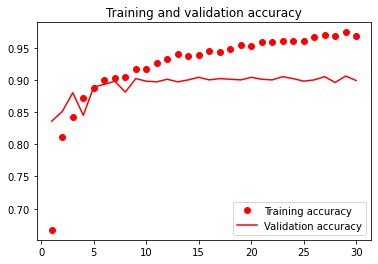

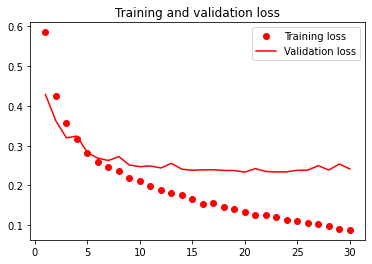

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(1, len(acc) + 1)

plt.plot(epoch, acc, 'ro', label='Training accuracy')
plt.plot(epoch, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoch, loss, 'ro', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
model.save('cats_vs_dogs_without_data_argumentation.h5')

In [12]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
conv_base.trainable = False

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 22s 215ms/step - loss: 0.5684 - acc: 0.7235 - val_loss: 0.4610 - val_acc: 0.8040
Epoch 2/30
100/100 [==============================] - 21s 206ms/step - loss: 0.4797 - acc: 0.7840 - val_loss: 0.3900 - val_acc: 0.8430
Epoch 3/30
100/100 [==============================] - 23s 225ms/step - loss: 0.4411 - acc: 0.8060 - val_loss: 0.3379 - val_acc: 0.8620
Epoch 4/30
100/100 [==============================] - 21s 213ms/step - loss: 0.4011 - acc: 0.8215 - val_loss: 0.3083 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 21s 208ms/step - loss: 0.3802 - acc: 0.8295 - val_loss: 0.3048 - val_acc: 0.8740
Epoch 6/30
100/100 [==============================] - 22s 225ms/step - loss: 0.3664 - acc: 0.8375 - val_loss: 0.2925 - val_acc: 0.8790
Epoch 7/30
100/100 [==============================] - 20s 204ms/step - loss: 0.3674 - acc: 0.8340 - val_lo

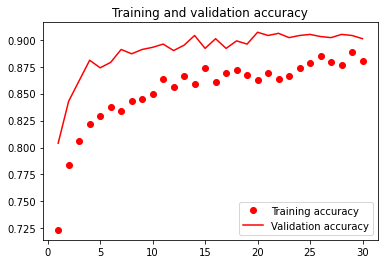

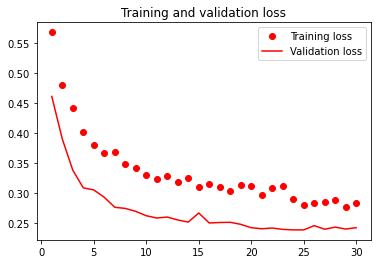

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(1, len(acc) + 1)

plt.plot(epoch, acc, 'ro', label='Training accuracy')
plt.plot(epoch, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoch, loss, 'ro', label='Training loss')
plt.plot(epoch, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model.save('cats_vs_dogs_with_data_argumentation.h5')

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc'])

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 10s 97ms/step - loss: 0.6885 - acc: 0.5350 - val_loss: 0.6634 - val_acc: 0.5860
Epoch 2/30
100/100 [==============================] - 9s 94ms/step - loss: 0.6622 - acc: 0.6080 - val_loss: 0.6539 - val_acc: 0.5840
Epoch 3/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6170 - acc: 0.6545 - val_loss: 0.6385 - val_acc: 0.6230
Epoch 4/30
100/100 [==============================] - 10s 103ms/step - loss: 0.5758 - acc: 0.6880 - val_loss: 0.6140 - val_acc: 0.6430
Epoch 5/30
100/100 [==============================] - 10s 101ms/step - loss: 0.5406 - acc: 0.7240 - val_loss: 0.6029 - val_acc: 0.6670
Epoch 6/30
100/100 [==============================] - 11s 108ms/step - loss: 0.5231 - acc: 0.7385 - val_loss: 0.5803 - val_acc: 0.6860
Epoch 7/30
100/100 [==============================] - 10s 104ms/step - loss: 0.4946 - acc: 0.7645 - val_loss: 0.6176 - val_acc: 0.6620
Epoch 8/30
100/100 [==============================] - 10s 

In [21]:
model.save('cats_vs_dogs_small1.h5')

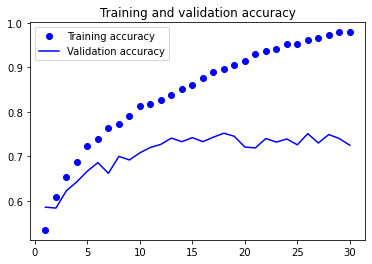

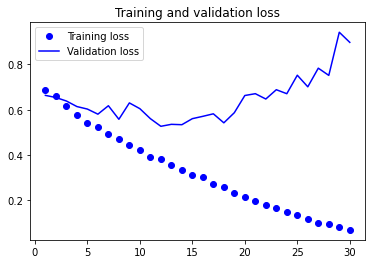

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc'])

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=validation_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 222ms/step - loss: 0.6924 - acc: 0.5240 - val_loss: 0.6892 - val_acc: 0.5330
Epoch 2/100
100/100 [==============================] - 22s 220ms/step - loss: 0.6875 - acc: 0.5440 - val_loss: 0.6825 - val_acc: 0.5060
Epoch 3/100
100/100 [==============================] - 22s 218ms/step - loss: 0.6742 - acc: 0.5870 - val_loss: 0.6718 - val_acc: 0.5540
Epoch 4/100
100/100 [==============================] - 21s 215ms/step - loss: 0.6724 - acc: 0.5815 - val_loss: 0.6518 - val_acc: 0.6140
Epoch 5/100
100/100 [==============================] - 23s 227ms/step - loss: 0.6515 - acc: 0.6175 - val_loss: 0.6885 - val_acc: 0.5860
Epoch 6/100
100/100 [==============================] - 22s 215ms/step - loss: 0.6437 - acc: 0.6210 - val_loss: 0.6064 - val_acc: 0.6720
Epoch 7/100
100/100 [==============================] - 22s 218ms/step - loss: 0.6291 - acc: 0.6440 - val_loss: 0.6552 - val_acc: 0.6000
Epoch 8/100
100/100 [===========================

In [27]:
model.save('cats_vs_dogs_small2.h5')

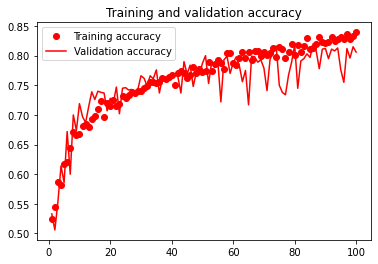

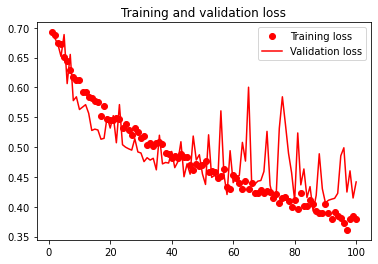

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(1, len(acc) + 1)

plt.clf()

plt.plot(epoch, acc, 'ro', label='Training accuracy')
plt.plot(epoch,  val_acc, 'r', label='Validation accuracy')
plt.legend()
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epoch, loss, 'ro', label='Training loss')
plt.plot(epoch,  val_loss, 'r', label='Validation loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()


In [29]:
from keras.models import load_model
model = load_model('cats_vs_dogs_small2.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [30]:
image_path = os.path.join(test_dir, 'cats/cat.1700.jpg')

In [31]:
from keras.preprocessing import image

img = image.load_img(image_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img, axis=0)
img_tensor = img_tensor / 255

print(img_tensor.shape)

(1, 150, 150, 3)


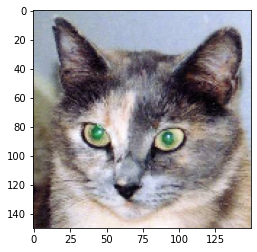

In [32]:
plt.imshow(img_tensor[0])
plt.show()

In [33]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [34]:
activations = activation_model.predict(img_tensor)

In [35]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


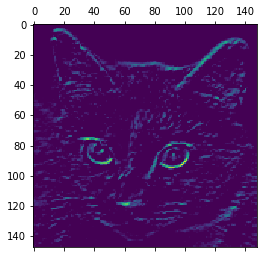

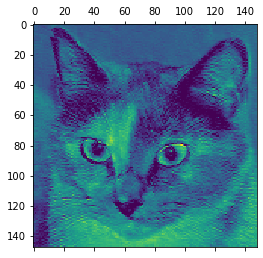

In [36]:
plt.matshow(first_layer_activation[0,:,:,4], cmap='viridis')
plt.matshow(first_layer_activation[0,:,:,7], cmap='viridis')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


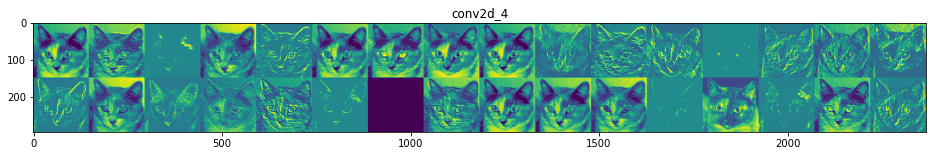

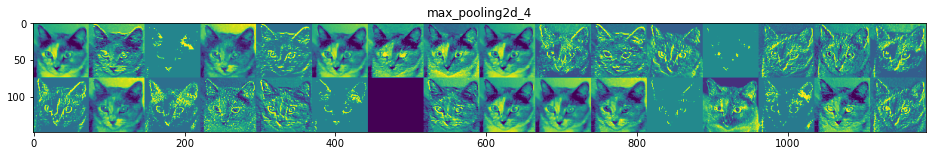

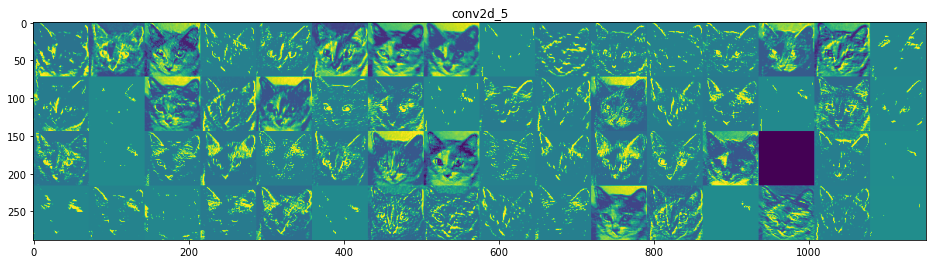

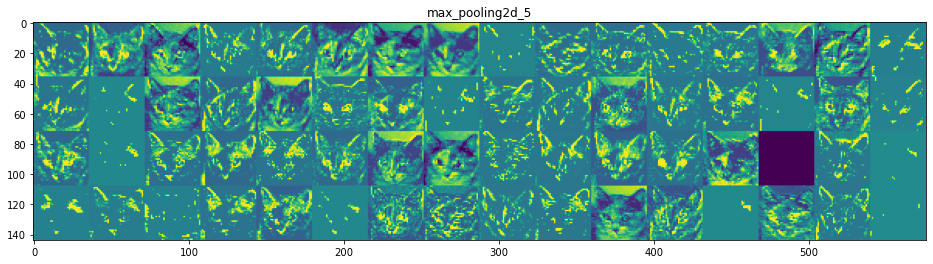

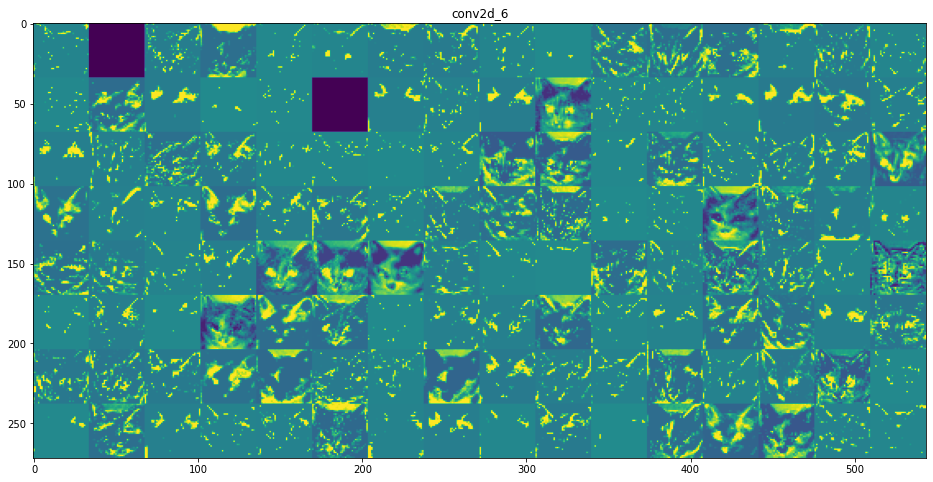

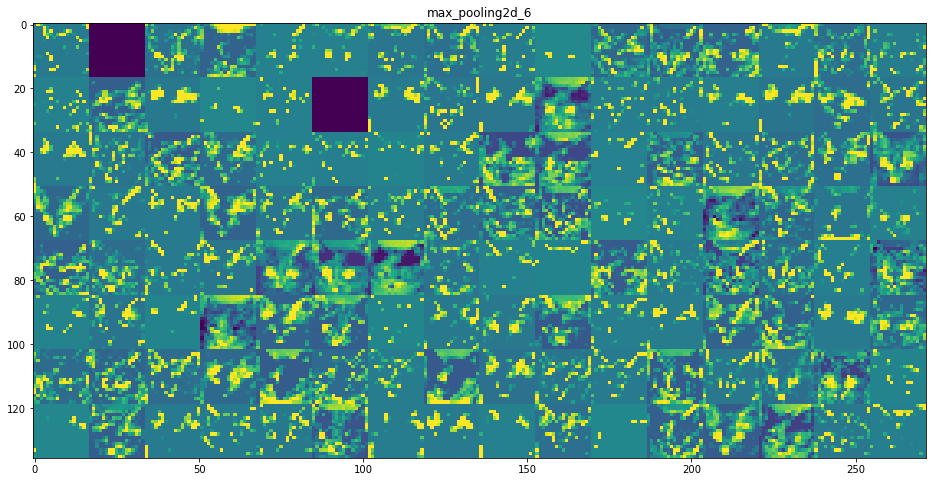

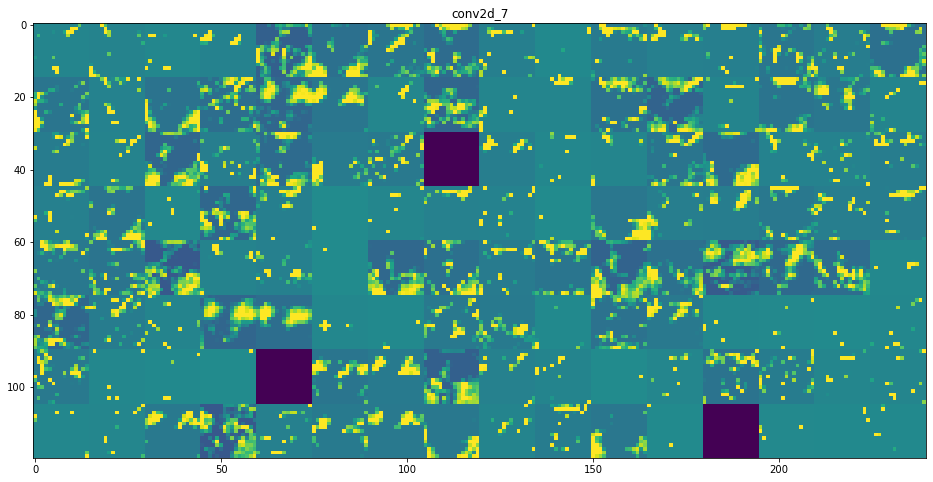

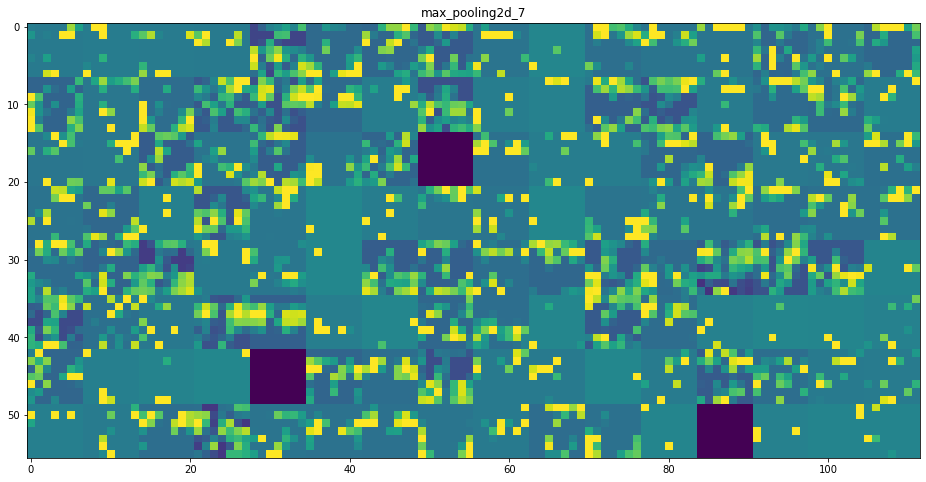

In [37]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
            :, :,
            col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [38]:
from keras.applications import VGG16
from keras import backend as K
model = VGG16(weights='imagenet',
include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [39]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
grads = K.gradients(loss, model.input)[0]

print(grads.shape)

(None, None, None, 3)


In [40]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

ValueError: Tensor("Const:0", shape=(4,), dtype=int32) must be from the same graph as Tensor("Square:0", shape=(None, None, None, 3), dtype=float32) (graphs are <tensorflow.python.framework.ops.Graph object at 0x7fe8b8d7d8d0> and FuncGraph(name=keras_graph, id=140636664550224)).

In [41]:
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

ValueError: Tensor Tensor("Mean:0", shape=(), dtype=float32) is not an element of this graph.

In [42]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

NameError: name 'iterate' is not defined

In [43]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [44]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

In [45]:
plt.imshow(generate_pattern('block3_conv1', 0))

ValueError: Tensor("Const_1:0", shape=(3,), dtype=int32) must be from the same graph as Tensor("strided_slice_1:0", shape=(None, None, None), dtype=float32) (graphs are <tensorflow.python.framework.ops.Graph object at 0x7fe8b8d7d8d0> and FuncGraph(name=keras_graph, id=140636664550224)).

In [46]:
layer_name = 'block1_conv1'
size = 64
margin = 5
results = np.zeros((8 * size+7* margin, 8 * size+7* margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
        vertical_start: vertical_end, :] = filter_img
    plt.figure(figsize=(20, 20))
    plt.imshow(results)

ValueError: Tensor("Const_2:0", shape=(3,), dtype=int32) must be from the same graph as Tensor("strided_slice_2:0", shape=(None, None, None), dtype=float32) (graphs are <tensorflow.python.framework.ops.Graph object at 0x7fe8b8d7d8d0> and FuncGraph(name=keras_graph, id=140636664550224)).

In [47]:
from keras.applications import VGG16

model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 4s 0us/step


In [48]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

img_path = '../input/elephant/elephant.jpg'
img = image.load_img(img_path,target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [49]:
preds = model.predict(x)
print( decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]


In [50]:
np.argmax(preds[0])

386

In [51]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

In [52]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

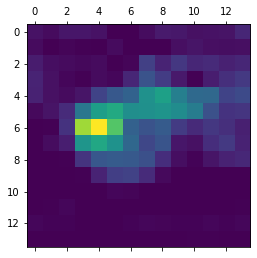

In [53]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [54]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('/elephant1.jpg', superimposed_img)

True